Based on: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [1]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
%matplotlib inline
np.set_printoptions(precision=5, suppress=True) # suppress scientific float notation

## Generating Sample Data

(150L, 2L)


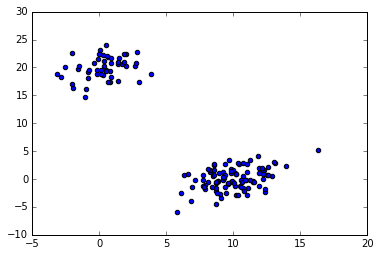

In [4]:
# generate two clusters: a with 100 points, b with 50
np.random.seed(4711)
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print X.shape  # 150 samples 
plt.scatter(X[:,0], X[:,1])
plt.show()
          

In [5]:
# generate the linkage matrix
Z = linkage(X, 'ward')

it never hurts to play around with some other common linkage methods like 'single', 'complete', 'average', ... and the different distance metrics like 'euclidean' (default), 'cityblock' aka Manhattan, 'hamming', 'cosine'... if you have the feeling that your data should not just be clustered to minimize the overall intra cluster variance in euclidean space. For example, you should have such a weird feeling with long (binary) feature vectors (e.g., word-vectors in text clustering).

In [7]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
c, coph_dists = cophenet(Z, pdist(X))
c

0.98001483875742679

In [8]:
Z[0]

array([ 52.     ,  53.     ,   0.04151,   2.     ])

## Plotting Dendrogram

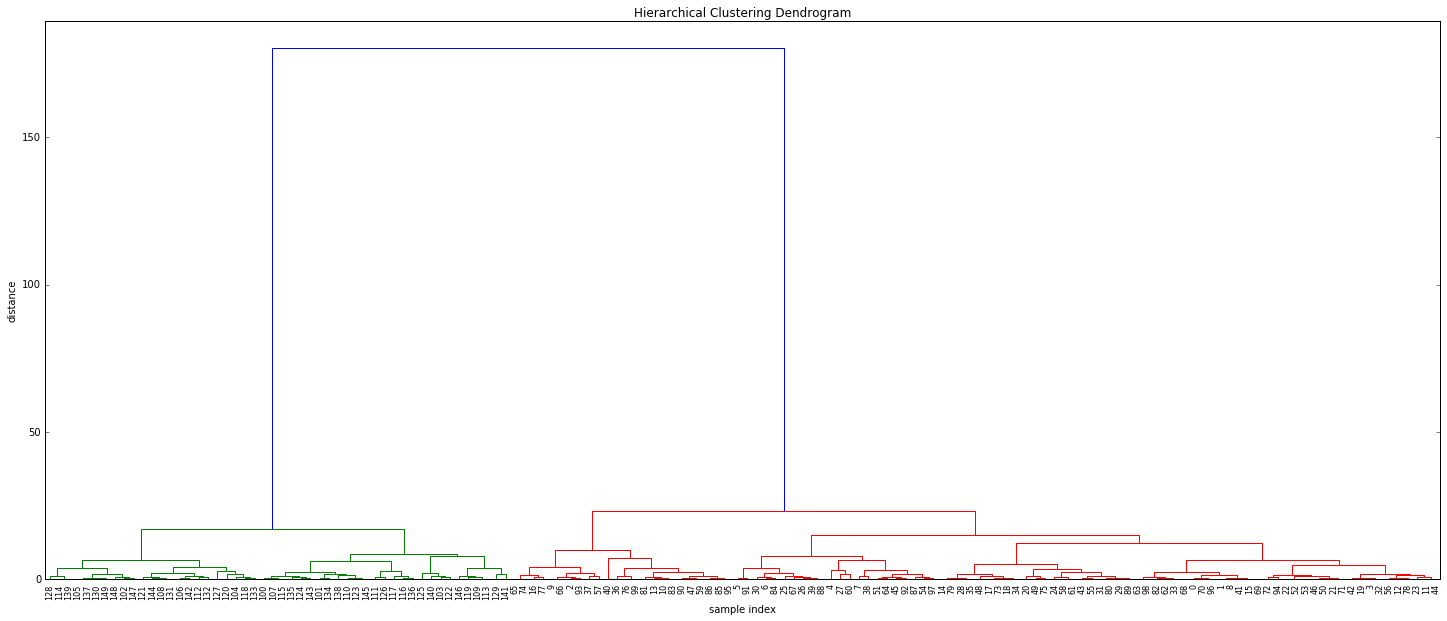

In [9]:
plt.figure(figsize=(25,10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

## Dendrogram Truncation

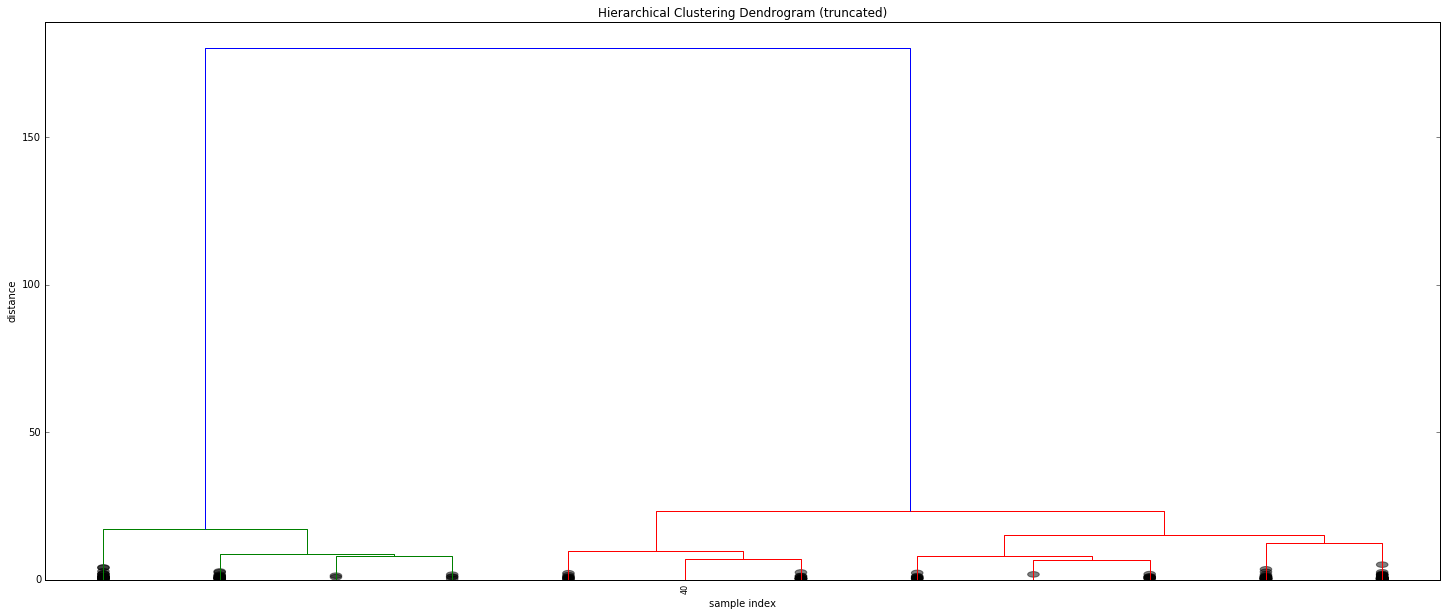

In [10]:
plt.figure(figsize=(25,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, truncate_mode='lastp', p=12,
           show_leaf_counts=False, leaf_rotation=90.,
           leaf_font_size=8., show_contracted=True)
plt.show()

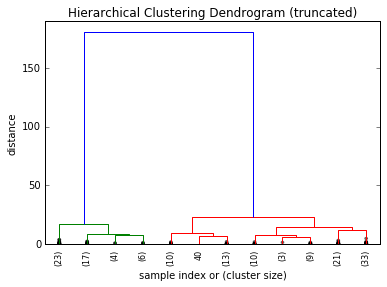

In [11]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(Z, truncate_mode='lastp', p=12,
           leaf_rotation=90.,
           leaf_font_size=8., show_contracted=True)
plt.show()

## Fancy Dendrogram

In [12]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

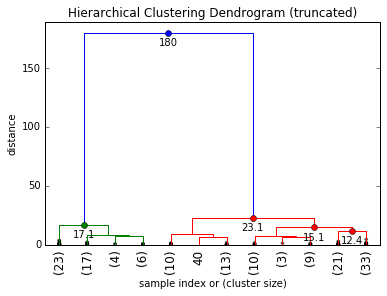

In [13]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

## Selecting a Distance Cut-Off aka Determining the Number of Clusters

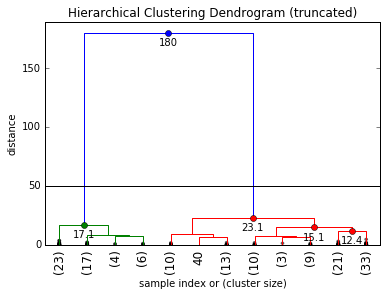

In [15]:
# set cut-off to 50
max_d = 50  # max_d as in max_distance
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

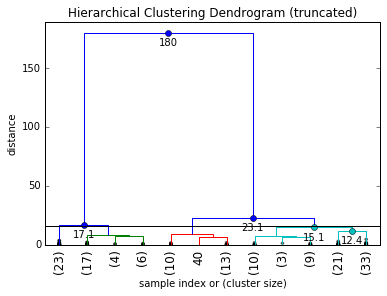

In [16]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=16,
)
plt.show()

## Automated Cut-Off Selection (or why you shouldn't rely on this)

### Inconsistent method

In [17]:
from scipy.cluster.hierarchy import inconsistent

depth = 5
incons = inconsistent(Z, depth)
incons[-10:]

array([[  1.80875,   2.17062,  10.     ,   2.44277],
       [  2.31732,   2.19649,  16.     ,   2.52742],
       [  2.24512,   2.44225,   9.     ,   2.37659],
       [  2.30462,   2.44191,  21.     ,   2.63875],
       [  2.20673,   2.68378,  17.     ,   2.84582],
       [  1.95309,   2.581  ,  29.     ,   4.05821],
       [  3.46173,   3.53736,  28.     ,   3.29444],
       [  3.15857,   3.54836,  28.     ,   3.93328],
       [  4.9021 ,   5.10302,  28.     ,   3.57042],
       [ 12.122  ,  32.15468,  30.     ,   5.22936]])

In [18]:
depth = 3
incons = inconsistent(Z, depth)
incons[-10:]

array([[  3.63778,   2.55561,   4.     ,   1.35908],
       [  3.89767,   2.57216,   7.     ,   1.54388],
       [  3.05886,   2.66707,   6.     ,   1.87115],
       [  4.92746,   2.7326 ,   7.     ,   1.39822],
       [  4.76943,   3.16277,   6.     ,   1.60456],
       [  5.27288,   3.56605,   7.     ,   2.00627],
       [  8.22057,   4.07583,   7.     ,   1.69162],
       [  7.83287,   4.46681,   7.     ,   2.07808],
       [ 11.38091,   6.2943 ,   7.     ,   1.86535],
       [ 37.25845,  63.31539,   7.     ,   2.25872]])

### Elbow Method

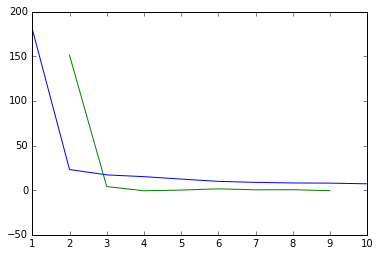

clusters: 2


In [19]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

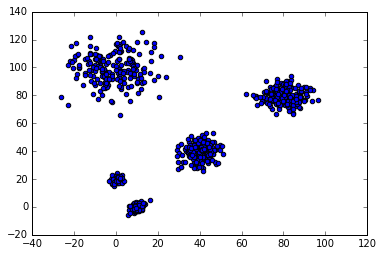

In [20]:
c = np.random.multivariate_normal([40, 40], [[20, 1], [1, 30]], size=[200,])
d = np.random.multivariate_normal([80, 80], [[30, 1], [1, 30]], size=[200,])
e = np.random.multivariate_normal([0, 100], [[100, 1], [1, 100]], size=[200,])
X2 = np.concatenate((X, c, d, e),)
plt.scatter(X2[:,0], X2[:,1])
plt.show()

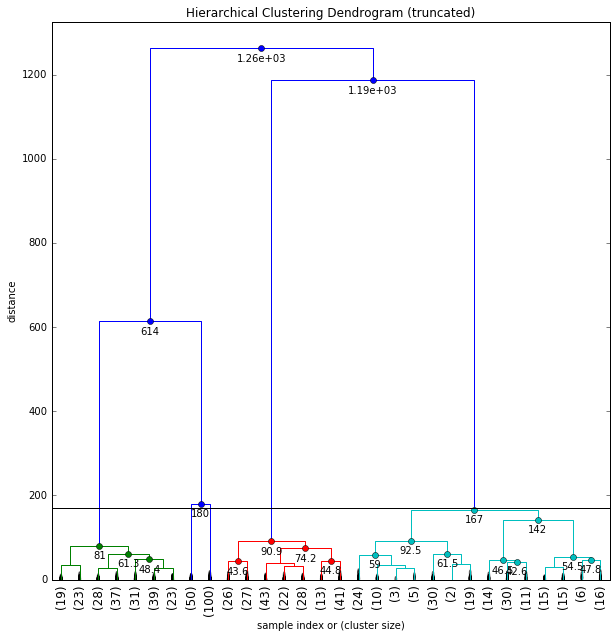

In [21]:
Z2 = linkage(X2, 'ward')
plt.figure(figsize=(10,10))
fancy_dendrogram(
    Z2,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=40,
    max_d=170,
)
plt.show()

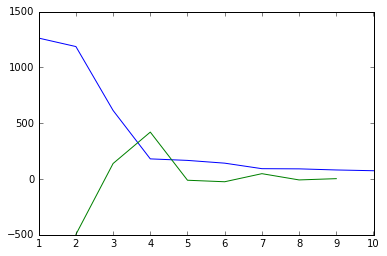

clusters: 4


In [22]:
last = Z2[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

## Retrieve the Clusters

### Knowing max_d:

In [23]:
from scipy.cluster.hierarchy import fcluster
max_d = 50
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Knowing k:

In [24]:
k=2
fcluster(Z, k, criterion='maxclust')

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Using the Inconsistency Method (default):

In [25]:
from scipy.cluster.hierarchy import fcluster
fcluster(Z, 8, depth=10)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Visualizing Clusters

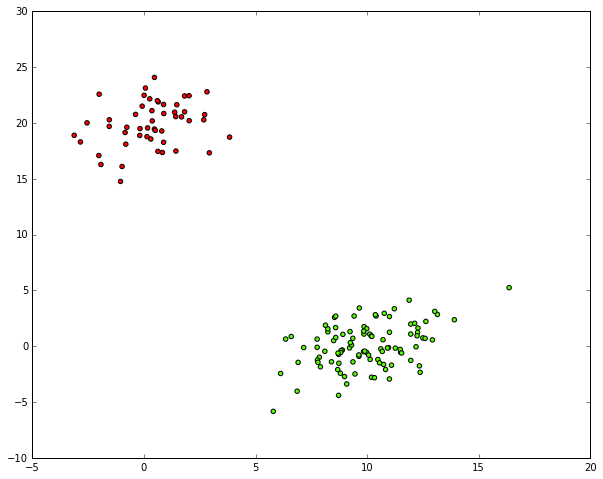

In [26]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()